Neural Network homework
=======================
As we have only a day to talk about a very useful, and different, machine learning algorithm I'd like to make sure you come in Wednesday having already implemented the basic ideas behind neural networks.  To that end, you are assigned two things (one is optional), **due Wednesday morning by 9 am**:
1.  **Required**: This notebook, but with the empty cells filled-in to answer the questions provided.
2.  **Optional**: A separate script, `neural_network_hw.py`, that uses a small neural network to simulate an [XOR gate](https://en.wikipedia.org/wiki/XOR_gate).  Other than `numpy`, you'll use no external libraries.  There'll be more directions at the end of this notebook about what is expected in this script.  If you want to potentially use neural networks in your capstone, you should do this second part.  

To submit your homework, put your completed jupyter notebook and (possibly your completed script) in a folder named *firstname_lastname* (that's your first and last names, by the way), **zip it**, and Slack it to me.  I encourage you to treat this as an individual assignment, but feel free to discuss details with the instructors and your peers.  

This homework relies heavily on three readings that are meant to help you understand and complete it:
* [DL4J's Introduction to Deep Neural Networks Overview](https://deeplearning4j.org/neuralnet-overview)
* [Carnegie Mellon's C.S. lecture: "Neural Networks: A Simple Problem"](https://www.cs.cmu.edu/afs/cs.cmu.edu/academic/class/15381-s06/www/nn.pdf)
* [i am trask's "Neural Network in 11 lines of Python"](https://iamtrask.github.io/2015/07/12/basic-python-network/)

The objectives of this notebook are to:
1. Introduce neural networks through a machine learning algorithm you already know: linear regression.
2. Introduce the neuron as the computational unit of neural networks.
3. During the training phase in a simple neural network, feed a signal forward through the network to make a prediction.  (this is **feed forward calculation**)
4. After calculating the prediction error, use partial derivatives and the chain rule to calculate the changes to the weights required to decrease the training error. (this is **back propogation**) Then repeat feed-forward and back propogation until the residuals are minimized so that the weights are finally trained.  Once the weights are trained, the model can now predict on new data.
5. Extrapolate feed-forward and back-propogation to a classification problem.
6. Introduce multi-layer networks.
7. In the optional `neural_network_hw.py` script, implement a multi-layer neural network to solve the [XOR problem](https://en.wikipedia.org/wiki/Perceptrons_%28book%29#The_XOR_affair), which contributed to an [A.I. Winter.](https://en.wikipedia.org/wiki/AI_winter)

There are side objectives too:  practicing your [Markdown](http://daringfireball.net/projects/markdown/basics), embedding equations in a jupyter notebook with [MathJax](https://cdn.mathjax.org/mathjax/latest/test/examples.html), practicing [partial differential equations](https://www.khanacademy.org/math/multivariable-calculus/multivariable-derivatives/partial-derivatives/v/partial-derivatives-introduction), practicing the [chain rule](https://www.khanacademy.org/math/ap-calculus-ab/product-quotient-chain-rules-ab/chain-rule-ab/v/chain-rule-introduction), and of course ... [plotting](http://matplotlib.org/examples/)!

Ok. Let's begin.  Obviously you can add cells in a section if you need it.

In [14]:
# imports
import numpy as np
from numpy.linalg import inv
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams.update({'font.size': 14})

In [15]:
# Raw data
X = np.array([0.5, 2.5, 2.6, 3.5, 4.6, 4.8, 5, 6.2, 7.4, 8.1, 8.3, 9.2, 9.7])
y = np.array([4.6, 7.4, 5.7, 11.6, 11.0, 13.0, 11.9, 15.0, 19.0, 16.9, 19.1, 21.9, 21.3])

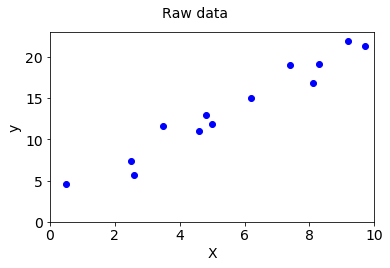

In [16]:
# Plot data
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(X, y, 'bo', label = 'data')
ax.set_xlabel('X', fontsize = 14) 
ax.set_ylabel('y', fontsize = 14)
ax.set_xlim([0, 10])
ax.set_ylim([0, 23])
fig.suptitle('Raw data', fontsize = 14)
fig.tight_layout(pad=2);

Let's predict **y** as function of **X**.  Let's not use regularization, but rather solve this linear regression using the closed form solution we know: ![least_squares](images/least_squares.png)  
However, we can agree that this equation is pixelated and hard to read.  Redo this equation using Markdown and MathJax in the cell below.  Some excellent examples of what MathJax can do can be found [here](https://cdn.mathjax.org/mathjax/latest/test/sample.html) and you can see the MathJax code by viewing the source code in your browser (type in  `view-source:https://cdn.mathjax.org/mathjax/latest/test/sample.html` to the browser address window if you can't figure that out.)

#### Question 1: Redo the least squares closed form algebraic equation.  Some starter code is given below (double click on this cell.)

$$
\theta = (X^T X)^{-1} X^T \vec{y}
$$

#### Question 2: Use numpy to solve for the $\theta$ coefficients of your linear least squares problem.  Don't forget to add a column of 1s to X so that you get an intercept.  But instead of using $\theta$ use $\boldsymbol{w}$ (for weight).  What is the slope ($\boldsymbol{w_1}$)?  What is the intercept ($\boldsymbol{w_0})$?  Plot the regression versus the data using a red line.

In [17]:
# get coefficients

X_m = np.hstack((np.ones((len(X),1)), X.reshape(len(X),1)))
X_m
T1 = inv(X_m.T.dot(X_m))
T2 = X_m.T.dot(y.reshape(len(y),1))
w = T1.dot(T2)
w

array([[ 2.78799428],
       [ 1.96348169]])

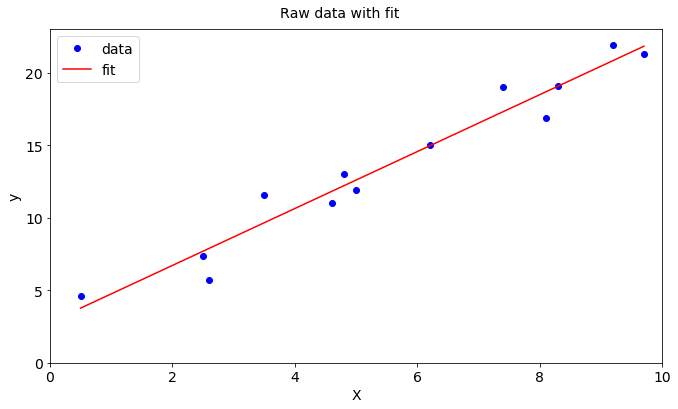

In [18]:
# Plot data and regression
y_r = w[1]*X + w[0]
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(X, y, 'bo', label = 'data')
ax.plot(X, y_r, 'r-', label = 'fit')
ax.set_xlabel('X', fontsize = 14) 
ax.set_ylabel('y', fontsize = 14)
ax.set_xlim([0, 10])
ax.set_ylim([0, 23])
fig.suptitle('Raw data with fit', fontsize = 14)
ax.legend()
fig.tight_layout(pad=2);

Great.  So what's this have to do with neural networks?  We are going to use the simplest computation unit of a neural network, a linear neuron (a.k.a. node, neurode, unit), to calcuate the weights determined from the linear regression, and in the process demonstrate **feed forward** calculation and **back propogation**.

Consider the following neuron ![simple_neuron](images/simple_neuron.png).

Data ($\boldsymbol{X}$) is flowing into this neuron through its *synapses* (otherwise known as weights).  From there the weighted data is summed: $w_0x_0$ + $w_1x_1$, (equivalently $\boldsymbol{w} \cdot \boldsymbol{X}$, or $\boldsymbol{w}^{T}\boldsymbol{X}$).  Then this weighted sum is evaluated through an activation function, $\boldsymbol{\phi}$, to get prediction $y_p$.  For now, assume that the activation function only multiplies the sum by 1!  This makes this neuron a linear neuron and the calculation of $y_p$ very easy.

To start forward calculations, assumptions need to be made about the starting values of the weights.  In modern neural nets, determining the proper initializations of the weights is an active area of research. Assume for now they were initialized according to a uniform distributions between -1 and 1, with $w_0$ = -0.5, and $w_1$ = 0.25.

Note that $x_0$ and $x_1$ correspond to the two values associated with each row of $\boldsymbol{X}$, where $\boldsymbol{X}$ is:

In [19]:
X_lsq = np.vstack([np.ones(len(X)), X]).T
print("X (with a constant) is:")
print("   x0   x1")
print(X_lsq)

X (with a constant) is:
   x0   x1
[[ 1.   0.5]
 [ 1.   2.5]
 [ 1.   2.6]
 [ 1.   3.5]
 [ 1.   4.6]
 [ 1.   4.8]
 [ 1.   5. ]
 [ 1.   6.2]
 [ 1.   7.4]
 [ 1.   8.1]
 [ 1.   8.3]
 [ 1.   9.2]
 [ 1.   9.7]]


#### Question 3:  With the assumed weights $w_0$ = -0.5, $w_1$ = 0.25 and the first row of $\boldsymbol{X}$, what value of $y_p$ results from feed-forward calculation? (p.s. please don't make this hard).

In [20]:
w = np.array([-0.5, 0.25]).reshape(-1,1)
y_p = X_lsq[0].dot(w)
y_p

array([-0.375])

Obviously a $y_p$ value of -0.375 is not near the first $y_{train}$ value of 4.6.  The weights need to be modified before they predict on the next value of y.  Corrections to the weights are applied in a process called **back propogation**.  In this process, partial derivates, the chain rule, and gradient descent are used to predict corrections for each of the weights before feed-forward calculation on the next training sample.

Recall that the loss, or prediction error, for one prediction during training is
$$
E = \frac{1}{2}(y_{train} - y_p)^2
$$

and the goal is to calculate $\Delta w_0$ and $\Delta w_1$, and where $y_p$ = $\phi(w^{T}X)$.  Using **gradient descent** the change of weights can be approximated as: 

$$
\Delta w = - \alpha \frac{\partial E}{\partial w}
$$

and from the chain rule

$$
\frac{\partial E}{\partial w} = \frac{\partial E}{\partial \phi} \frac{\partial \phi}{\partial w}
$$

where $\phi$ is the activation function (multiplying by 1 in this case), so $y_p = \phi(w^{T}X) = w^{T}X$

#### Question 4:  Calculate by hand, and then express in MathJax in this cell, the equations that solve for $\Delta w_0$ and $\Delta w_1$.

$$
\Delta w_0 = - \alpha \frac{\partial E}{\partial w_0} = \alpha x_0 (y_t - w^{T}X)
$$

$$
\Delta w_1 = - \alpha \frac{\partial E}{\partial w_1} = \alpha x_1 (y_t - w^{T}X)
$$

See derivation below.

$$
\frac{\partial E}{\partial w} = \frac{\partial E}{\partial \phi} \frac{\partial \phi}{\partial w}
$$

$$
E = \frac{1}{2}(y_{train} - y_p)^2 = \frac{1}{2}(y_{train} - \phi(w^{T}X))^2
$$

$$
\frac{\partial E}{\partial \phi} = 2 \cdot \frac{1}{2}(y_t - \phi(w^{T}X)) \cdot -1 = -(y_t - \phi(w^{T}X))
$$

$$
\frac{\partial E}{\partial \phi} = -(y_t - \phi(w^{T}X))
$$

$$
\frac{\partial \phi}{\partial w} = \frac{\partial}{\partial w}(1 \cdot w^{T}X) = X
$$

$$
\frac{\partial E}{\partial w} = \frac{\partial E}{\partial \phi} \frac{\partial \phi}{\partial w}
$$

$$
\frac{\partial E}{\partial w} =  -(y_t - \phi(w^{T}X)) \cdot X
$$

$$
\frac{\partial E}{\partial w} =  -(y_t - w^{T}X) \cdot X
$$

$$
\Delta w = - \alpha \frac{\partial E}{\partial w}
$$

$$
\Delta w_0 = - \alpha \frac{\partial E}{\partial w_0} = -\alpha (-(y_t - w^{T}X)x_0)
$$

$$
\Delta w_0 = - \alpha \frac{\partial E}{\partial w_0} = \alpha x_0 (y_t - w^{T}X)
$$

$$
\Delta w_1 = - \alpha \frac{\partial E}{\partial w_1} = \alpha x_1 (y_t - w^{T}X)
$$

#### Question 5:  Use your $\Delta w$ equations to back propogate changes to your weights for each row in your training set.  Just pass through your data set once.  Are your $w_0$ and $w_1$ values similar to those predicted by the linear regression?  What if you continue to cycle through your data set?  Are your weights converging to the linear regression values?  You will need to write a simulation to answer these questions.  For me, convergence was highly dependent on learning rate.  Assume that the weights are initialized as $w_0 = -0.5$, and $w_1 = 0.25$

Simulation results
w0: [ 2.89038405], w1: [ 1.94015659]


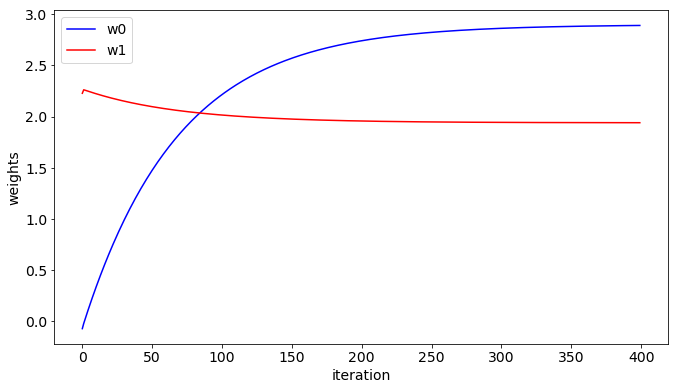

In [82]:
X = np.array([0.5, 2.5, 2.6, 3.5, 4.6, 4.8, 5, 6.2, 7.4, 8.1, 8.3, 9.2, 9.7])
y = np.array([4.6, 7.4, 5.7, 11.6, 11.0, 13.0, 11.9, 15.0, 19.0, 16.9, 19.1, 21.9, 21.3])
X = np.hstack((np.ones((len(X),1)), X.reshape(len(X),1)))

num_iter = 400

alpha = 0.006
w = np.array([-0.5, 0.25]).reshape(-1,1)
w0_lst, w1_lst = [], []
for n in range(num_iter):
    #print("Iteration {0}".format(n))
    for i in range(X.shape[0]):
        dw0 = alpha * X[i][0] * (y[i] - X[i].dot(w))
        dw1 = alpha * X[i][1] * (y[i] - X[i].dot(w))
        # print("Before update: w0 {0}, w1 {1}".format(w[0], w[1]))
        w[0] += dw0
        w[1] += dw1
        # print("After update: w0 {0}, w1 {1}".format(w[0], w[1]))
    w0_lst.append(np.asscalar(w[0]))
    w1_lst.append(np.asscalar(w[1]))   
    
iterations = list(range(num_iter))
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(iterations, w0_lst, 'b-', label = 'w0')
ax.plot(iterations, w1_lst, 'r-', label = 'w1')
ax.set_xlabel('iteration', fontsize = 14) 
ax.set_ylabel('weights', fontsize = 14)
ax.legend()
fig.tight_layout(pad=2);

print("Simulation results")
print("w0: {0}, w1: {1}".format(w[0], w[1]))

For classification problems a neuron with a linear activation function doesn't work well.  Additionally, neurons with solely linear behavior tend to be limited in their ability to learn non-linear features.  Use of the logistic function as an activation function (and other activation functions we'll learn about in class) addresses these liabilities.  Consider the following data, targets and neuron architecture.

![neuron_3inputs](images/neuron_3inputs.png)

This is the same neuron and data analyzed in Part 1 of [A Neural Network in 11 lines of Python](https://iamtrask.github.io/2015/07/12/basic-python-network/).  Note that there are four rows of data, and four predictions that are classes 1 and 0.  Additionally, the column $x_0$ is the bias column (the column where all values are 1 so that weight $w_0$ can represent the intercept).

The activation function $\phi$ is the standard logistic function, often referred to as the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).  It has the property of taking continuously valued input and mapping it to a 0-1 range, just as it did in logistic regression.

In this neuron:

$$
y_p = \phi(w^{T}X)
$$
$$
\phi(x) = \frac{1}{1 + e^{-x}}
$$

#### Question 6:  Say that we are training on the 2nd row of data ($x_0$, $x_1$, $x_2$ = 1, 1, 1 and $y_t$ = 1) and that our weights were $w_0$, $w_1$, $w_2$ = -0.5, 2, 1.  What would $y_p$ be in this feed forward calculation?  Do not threshold $y_p$ to 0 or 1, maintain its fractional value as calculated by the sigmoid function.  And what is the error in the prediction of this data point?

In [86]:
def sigmoid(x):
    return 1 / (1+np.exp(-x))

y_t = 1
w = np.array([-0.5, 2, 1]).reshape((-1,1))
X = np.array([1, 1, 1]).reshape((1,-1))
wTX = X.dot(w)
y_p = np.asscalar(sigmoid(wTX))
err = y_t - y_p
print("The predicted y_p is {0}".format(y_p))
print("The error is {0}".format(err))

The predicted y_p is 0.9241418199787566
The error is 0.07585818002124345


#### Question 7:  To correct the error the weights must be updated using back propogation, just as in the linear case.  However, now the activation function has a more complicated derivative than the linear case.  What are the equations now to update the weights?

$$
\Delta w_0 = - \alpha \frac{\partial E}{\partial w_0} = \alpha x_0 (y_t - \phi(w^{T}X)) \cdot \phi(w^{T}X)\cdot (1-\phi(w^{T}X))
$$

$$
\Delta w_1 = - \alpha \frac{\partial E}{\partial w_1} = \alpha x_1 (y_t - \phi(w^{T}X)) \cdot \phi(w^{T}X)\cdot (1-\phi(w^{T}X))
$$

$$
\Delta w_2 = - \alpha \frac{\partial E}{\partial w_2} = \alpha x_2 (y_t - \phi(w^{T}X)) \cdot \phi(w^{T}X)\cdot (1-\phi(w^{T}X))
$$

The derivation:


$$
\frac{\partial E}{\partial w} = \frac{\partial E}{\partial \phi} \frac{\partial \phi}{\partial w}
$$

$$
E = \frac{1}{2}(y_{train} - y_p)^2 = \frac{1}{2}(y_{train} - \phi(w^{T}X))^2
$$

$$
\frac{\partial E}{\partial \phi} = 2 \cdot \frac{1}{2}(y_t - \phi(w^{T}X)) \cdot -1 = -(y_t - \phi(w^{T}X))
$$

$$
\frac{\partial E}{\partial \phi} = -(y_t - \phi(w^{T}X))
$$

In the calculation of $\frac{\partial \phi}{\partial w}$ the derivative of the sigmoid needs to be considered.
[Derivative of sigmoid](http://www.ai.mit.edu/courses/6.892/lecture8-html/sld015.htm)

$$
\frac{\partial \phi}{\partial w} = \frac{\partial}{\partial w}(\phi(w^{T}X)) = \phi(w^{T}X) \cdot (1-\phi(w^{T}X)) \cdot X
$$

$$
\frac{\partial E}{\partial w} = \frac{\partial E}{\partial \phi} \frac{\partial \phi}{\partial w}
$$

$$
\frac{\partial E}{\partial w} =  -(y_t - \phi(w^{T}X)) \cdot \phi(w^{T}X)(1-\phi(w^{T}X)) \cdot X
$$

$$
\Delta w = - \alpha \frac{\partial E}{\partial w}
$$

$$
\Delta w_0 = - \alpha \frac{\partial E}{\partial w_0} = -\alpha (-(y_t - \phi(w^{T}X)))\cdot \phi(w^{T}X)(1-\phi(w^{T}X))x_0
$$

$$
\Delta w_0 = - \alpha \frac{\partial E}{\partial w_0} = \alpha x_0 (y_t - \phi(w^{T}X)) \cdot \phi(w^{T}X)\cdot (1-\phi(w^{T}X))
$$

$$
\Delta w_1 = - \alpha \frac{\partial E}{\partial w_1} = \alpha x_1 (y_t - \phi(w^{T}X)) \cdot \phi(w^{T}X)\cdot (1-\phi(w^{T}X))
$$

$$
\Delta w_2 = - \alpha \frac{\partial E}{\partial w_2} = \alpha x_2 (y_t - \phi(w^{T}X)) \cdot \phi(w^{T}X)\cdot (1-\phi(w^{T}X))
$$


#### Question 8:  Implement and try to understand the code of the "2-Layer Network" presented in the "Neural Network in 11 lines of Python" reference.   You should be able to converge on weights that perfectly fit the training data.

In [90]:
import numpy as np

# sigmoid function
def nonlin(x,deriv=False):
    if(deriv==True):
        return nonlin(x)*(1-nonlin(x))
    return 1/(1+np.exp(-x))
    
# input dataset
X = np.array([  [0,0,1],
                [0,1,1],
                [1,0,1],
                [1,1,1] ])
    
# output dataset            
y = np.array([[0,0,1,1]]).T
#y = np.array([[0,1,1,0]]).T #XOR

# seed random numbers to make calculation
# deterministic (just a good practice)
np.random.seed(1)

# initialize weights randomly with mean 0
syn0 = 2*np.random.random((3,1)) - 1

for iter in range(10000):

    # forward propagation
    l0 = X
    l1 = nonlin(np.dot(l0,syn0))

    # how much did we miss?
    l1_error = y - l1

    # multiply how much we missed by the 
    # slope of the sigmoid at the values in l1
    l1_delta = l1_error * nonlin(l1,True)

    # update weights
    syn0 += np.dot(l0.T,l1_delta)

print("Output After Training:")
print(l1)

Output After Training:
[[  7.21568063e-04]
 [  4.80986190e-04]
 [  9.99592413e-01]
 [  9.99388522e-01]]


Let's see if this neuron can learn another logical function, the exclusive or (XOR).  Subsitute this X and y array into your 2-layer network and see if it converges.

![XOR_data](images/XOR_data.png)

#### Question 9:  Unless you did something, it shouldn't converge.  In fact, it's impossible that it converged.  Why is that?  (May have to do some reading on this one.)

XOR (Exclusive OR) requires non-linear modeling abilities, which requires more than two layers.

Ok, you've been playing around with *one* neuron this entire time, and only a 2-layer network (input layer, output layer).  How about a neural network?  How about Deep Learning (a.k.a multiple layers in between the input and output layers, called hidden layers, that are comprised of 10s to 1000s of neurons)?  

In between layers, each neuron is most often *fully connected* to all the neurons in the following layer.  For instance, the picture below is of a one hidden layer network with 2 input nodes, 3 hidden layer nodes, and one output node.  All the layers are fully connected (in Keras known as Dense).  You'll notice that six weights are needed between the input and hidden layer, and 3 weights are needed to connect the hidden layer to the output layer.

![fully_connected](images/fully_connected.png)

To solve the XOR problem you'll need a **neural network with hidden layers**.



### Optional
#### Question 10:  In `neural_network_hw.py` write a 3 layer (input-hidden-output) neural network to solve the XOR problem.  In the interest of time I suggest that you use the "3-Layer Neural Network" code presented in "A Neural Network in 11 lines of Python."  But make this code your own - rename variables to make sense (syn?), code additional functions if necessary (maybe a class?), and provide detailed comments on each line about what it's doing.  You might as well put in an if-name-main block, too!  If you came into a job interview and someone asked you how you would code a neural network from scratch, this is what you could desribe to them.  Additionally, the architecture used by the author is not ideal (it can be simpler) AND it's missing one VERY important hyperparameter associated with model convergence, AND the math for the derivative is wrong (though the code still works).  So fix it!  Let this be a lesson not to trust even very good sample code (and a very nice reference) on the web.